In [2]:
pip install ucimlrepo

In [3]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

ds = fetch_ucirepo(id=235)

X_raw = ds.data.features
y_raw = ds.data.targets
meta = ds.metadata

print("Loaded:", meta["name"])
print("Shape:", X_raw.shape)

df = pd.concat([X_raw, y_raw], axis=1)

/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Loaded: Individual Household Electric Power Consumption
Shape: (2075259, 9)


In [4]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')


Added best paramter for Decision, Ridge for Linear Regression

Multioutput Train 5000


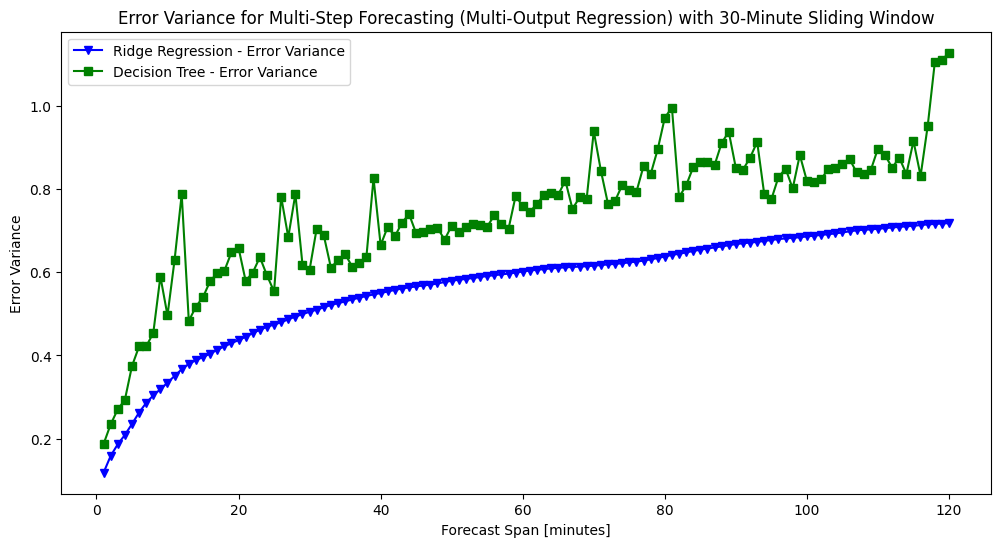

Ridge Regression (Linear) - MAE: 0.588791911663518, MSE: 0.6146593541130569, R²: 0.19311314609367766
Decision Tree - MAE: 0.6197549730203239, MSE: 0.7720219091903865, R²: -0.013462438301804372


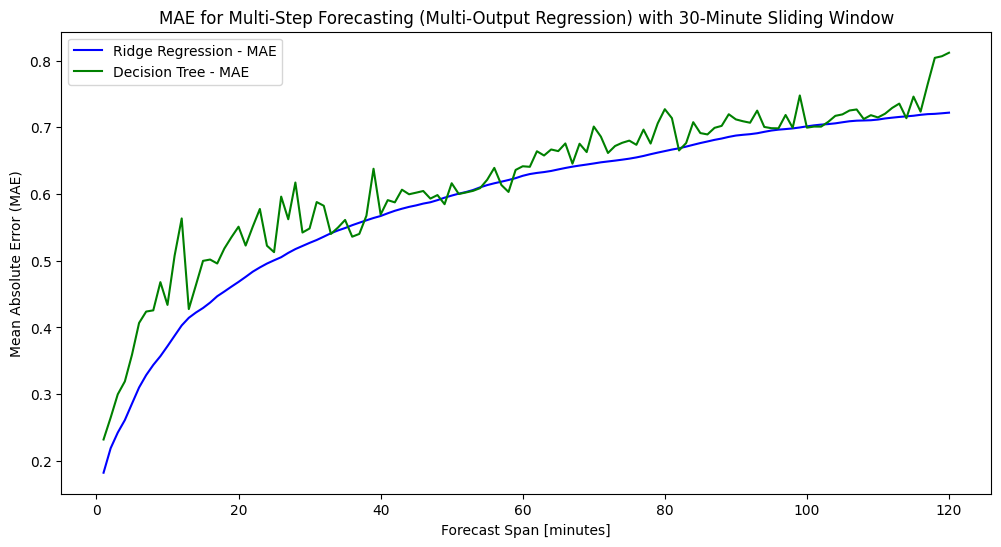

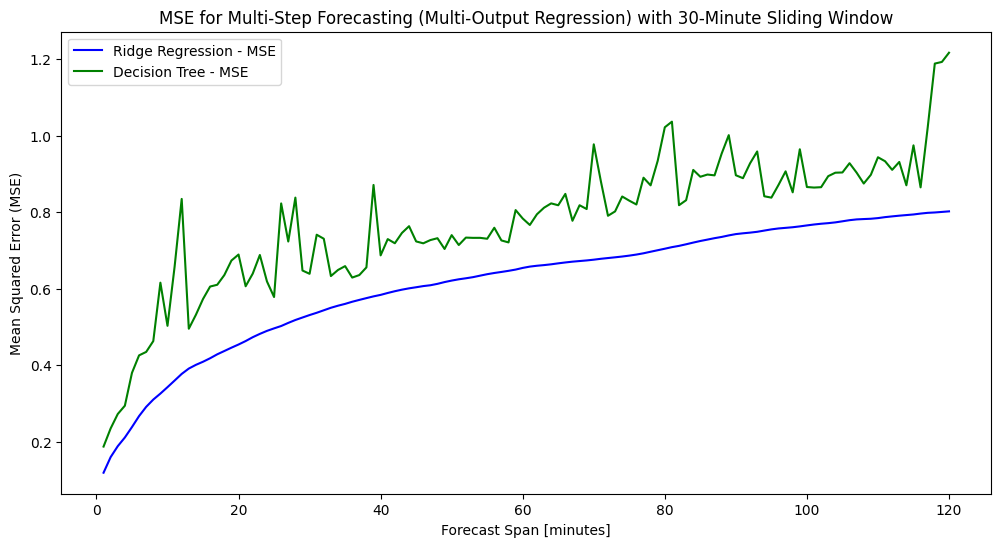

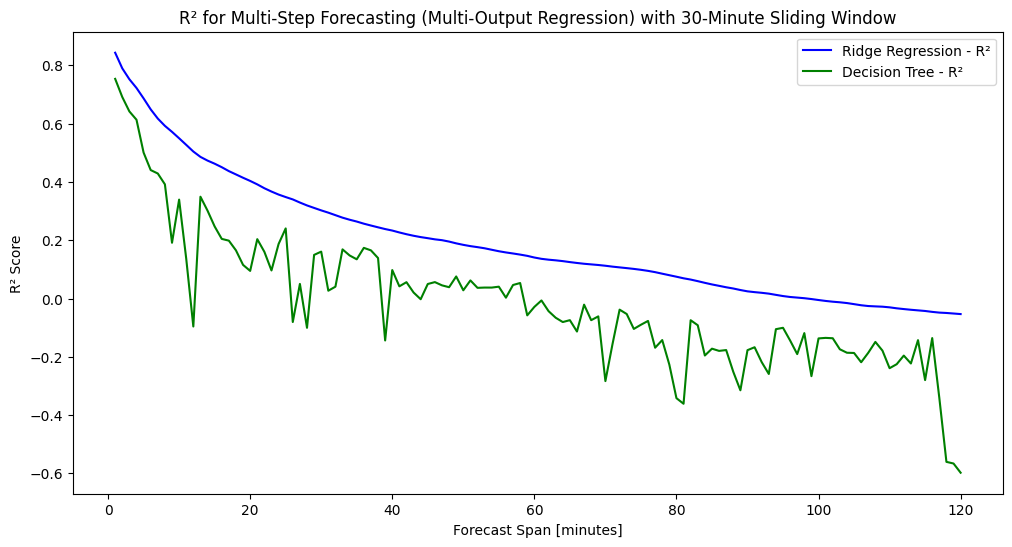

In [5]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Make a copy to avoid SettingWithCopyWarning
df = df.copy()

# Select 'Global_active_power' column
df = df[['Global_active_power']]

# Handle missing values correctly
df['Global_active_power'] = df['Global_active_power'].fillna(df['Global_active_power'].mean())

# Create Multi-Step Sliding Window Features (One model per minute ahead)
def create_sliding_window(df, window_size=30, forecast_horizon=120):
    X = []
    y = []

    for i in range(window_size, len(df) - forecast_horizon):
        X.append(df['Global_active_power'].iloc[i-window_size:i].values)  # Last 30 values as features
        y.append(df['Global_active_power'].iloc[i+1:i+forecast_horizon+1].values)  # Next 120 values as target

    return np.array(X), np.array(y)

# Set parameters
window_size = 30  # 30 minutes as input (30 past values)
forecast_horizon = 120  # Predicting next 120 minutes (1 model per minute)

# Create the sliding window data (using 30-minute window and 120 steps ahead)
X, y = create_sliding_window(df, window_size=window_size, forecast_horizon=forecast_horizon)

# Limit training set size to 5,000 samples as per the paper's setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = X_train[:5000]  # Limit to first 5,000 samples
y_train = y_train[:5000]

# Standardize the features (scale after limiting the training set to 5000 samples)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)  # Reshape for scaling
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)  # Reshape for scaling

# Multi-Output Regression: Ridge for Linear Regression and Decision Tree with specified parameters
ridge_model = MultiOutputRegressor(Ridge(alpha=1.0))  # Ridge regression for linear model with regularization
dt_model = MultiOutputRegressor(DecisionTreeRegressor(max_depth=5, max_features='log2', min_samples_leaf=4, min_samples_split=2))

# Train the models
ridge_model.fit(X_train_scaled, y_train)  # Train Ridge model for all forecast steps
dt_model.fit(X_train_scaled, y_train)  # Train Decision Tree model for all forecast steps

# Predictions
y_pred_ridge = ridge_model.predict(X_test_scaled)
y_pred_dt = dt_model.predict(X_test_scaled)

# Evaluate the models
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)


# Calculate Error Variance for each forecast step (t+1 to t+120)
error_ridge = y_test - y_pred_ridge
error_dt = y_test - y_pred_dt

# Compute variance for each forecast step (across all samples)
error_variance_ridge = np.var(error_ridge, axis=0)
error_variance_dt = np.var(error_dt, axis=0)

# Plot Error Variance for each forecast step (t+1 to t+120)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), error_variance_ridge, label='Ridge Regression - Error Variance', color='blue', marker='v', linestyle='-', markersize=6)
plt.plot(np.arange(1, forecast_horizon + 1), error_variance_dt, label='Decision Tree - Error Variance', color='green', marker='s', linestyle='-', markersize=6)

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Error Variance')
plt.title(f'Error Variance for Multi-Step Forecasting (Multi-Output Regression) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()


print(f"Ridge Regression (Linear) - MAE: {mae_ridge}, MSE: {mse_ridge}, R²: {r2_ridge}")
print(f"Decision Tree - MAE: {mae_dt}, MSE: {mse_dt}, R²: {r2_dt}")

# Plot MAE for each forecast step (t+1 to t+120)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), np.mean(np.abs(y_test - y_pred_ridge), axis=0), label='Ridge Regression - MAE', color='blue')
plt.plot(np.arange(1, forecast_horizon + 1), np.mean(np.abs(y_test - y_pred_dt), axis=0), label='Decision Tree - MAE', color='green')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title(f'MAE for Multi-Step Forecasting (Multi-Output Regression) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot MSE for each forecast step (t+1 to t+120)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), np.mean(np.square(y_test - y_pred_ridge), axis=0), label='Ridge Regression - MSE', color='blue')
plt.plot(np.arange(1, forecast_horizon + 1), np.mean(np.square(y_test - y_pred_dt), axis=0), label='Decision Tree - MSE', color='green')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'MSE for Multi-Step Forecasting (Multi-Output Regression) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Calculate R² for each forecast step (t+1 to t+120)
r2_ridge_steps = [r2_score(y_test[:, i], y_pred_ridge[:, i]) for i in range(forecast_horizon)]
r2_dt_steps = [r2_score(y_test[:, i], y_pred_dt[:, i]) for i in range(forecast_horizon)]

# Plot R² for each forecast step (t+1 to t+120)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), r2_ridge_steps, label='Ridge Regression - R²', color='blue')
plt.plot(np.arange(1, forecast_horizon + 1), r2_dt_steps, label='Decision Tree - R²', color='green')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('R² Score')
plt.title(f'R² for Multi-Step Forecasting (Multi-Output Regression) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()




multimodel regression 5000 , with ridge and best parametres

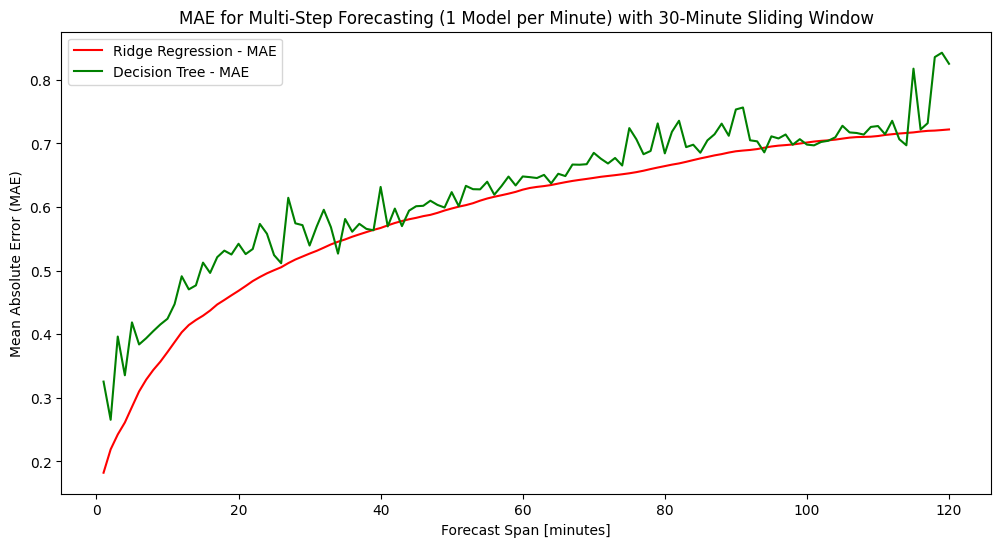

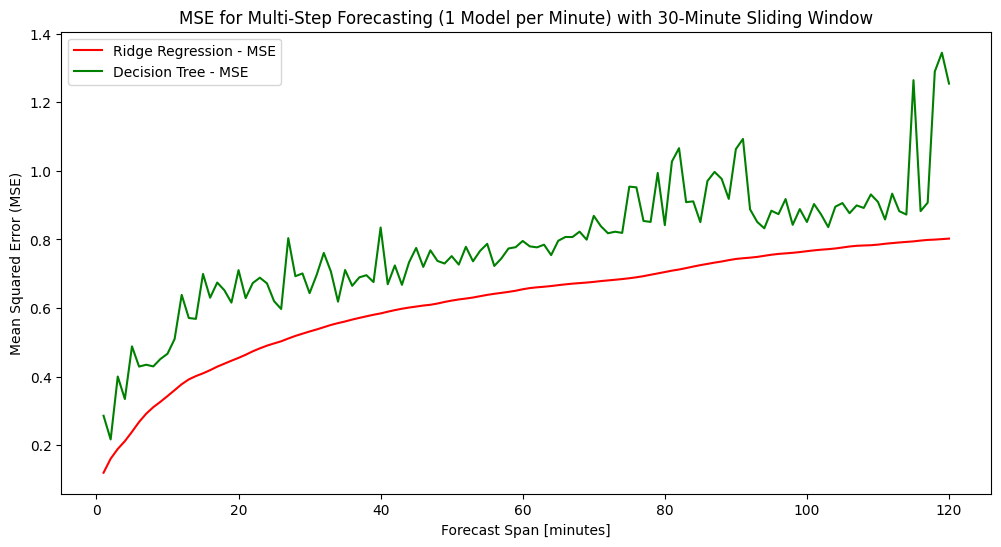

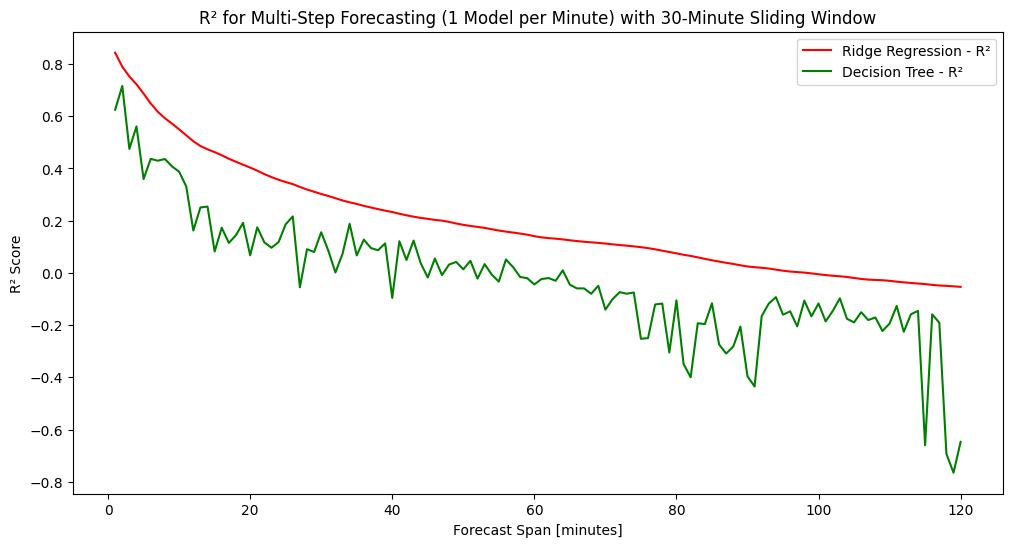

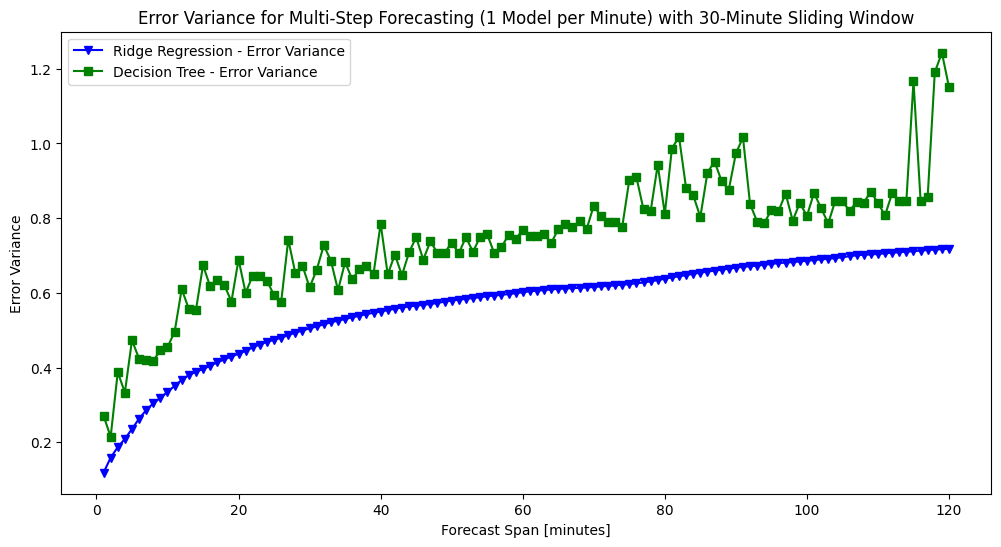

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Make a copy to avoid SettingWithCopyWarning
df = df.copy()

# Select 'Global_active_power' column
df = df[['Global_active_power']]

# Handle missing values correctly
df['Global_active_power'] = df['Global_active_power'].fillna(df['Global_active_power'].mean())

# Create Multi-Step Sliding Window Features (One model per minute ahead)
def create_sliding_window(df, window_size=30, forecast_horizon=120):
    X = []
    y = []

    for i in range(window_size, len(df) - forecast_horizon):
        X.append(df['Global_active_power'].iloc[i-window_size:i].values)  # Last 30 values as features
        y.append(df['Global_active_power'].iloc[i+1:i+forecast_horizon+1].values)  # Next 120 values as target

    return np.array(X), np.array(y)

# Set parameters
window_size = 30  # 30 minutes as input (30 past values)
forecast_horizon = 120  # Predicting next 120 minutes (1 model per minute)

# Create the sliding window data (using 30-minute window and 120 steps ahead)
X, y = create_sliding_window(df, window_size=window_size, forecast_horizon=forecast_horizon)

# Limit training set size to 5,000 samples as per the paper's setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = X_train[:5000]  # Limit to first 5,000 samples
y_train = y_train[:5000]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)  # Reshape for scaling
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)  # Reshape for scaling

# Store MAE, MSE, R² for each forecast step for both models
mae_scores_lr = np.zeros(forecast_horizon)
mse_scores_lr = np.zeros(forecast_horizon)
r2_scores_lr = np.zeros(forecast_horizon)

mae_scores_dt = np.zeros(forecast_horizon)
mse_scores_dt = np.zeros(forecast_horizon)
r2_scores_dt = np.zeros(forecast_horizon)

# Train models for each step in the forecast horizon
models_lr = [Ridge(alpha=1.0) for _ in range(forecast_horizon)]  # Ridge regularization for Linear Regression
models_dt = [DecisionTreeRegressor(max_depth=5, max_features='log2', min_samples_leaf=4, min_samples_split=2) for _ in range(forecast_horizon)]  # Best parameters for Decision Tree

# Fit the models
for i in range(forecast_horizon):
    models_lr[i].fit(X_train_scaled, y_train[:, i])  # Train Ridge model for each step
    models_dt[i].fit(X_train_scaled, y_train[:, i])  # Train Decision Tree model for each step

# Get predictions and calculate metrics for each forecast step
for i in range(forecast_horizon):
    y_pred_lr = models_lr[i].predict(X_test_scaled)
    y_pred_dt = models_dt[i].predict(X_test_scaled)

    # Calculate MAE, MSE, and R² for each step in the forecast horizon
    mae_scores_lr[i] = mean_absolute_error(y_test[:, i], y_pred_lr)
    mse_scores_lr[i] = mean_squared_error(y_test[:, i], y_pred_lr)
    r2_scores_lr[i] = r2_score(y_test[:, i], y_pred_lr)

    mae_scores_dt[i] = mean_absolute_error(y_test[:, i], y_pred_dt)
    mse_scores_dt[i] = mean_squared_error(y_test[:, i], y_pred_dt)
    r2_scores_dt[i] = r2_score(y_test[:, i], y_pred_dt)

# Calculate Error Variance for each forecast step (t+1 to t+120)
error_ridge = np.zeros_like(y_test)
error_dt = np.zeros_like(y_test)

# Get predictions and calculate errors for each forecast step
for i in range(forecast_horizon):
    y_pred_lr = models_lr[i].predict(X_test_scaled)
    y_pred_dt = models_dt[i].predict(X_test_scaled)

    # Store the errors for each step
    error_ridge[:, i] = y_test[:, i] - y_pred_lr
    error_dt[:, i] = y_test[:, i] - y_pred_dt

# Calculate Error Variance for each forecast step (t+1 to t+120)
error_variance_ridge = np.var(error_ridge, axis=0)
error_variance_dt = np.var(error_dt, axis=0)

# Plot MAE for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), mae_scores_lr, label='Ridge Regression - MAE', color='red')
plt.plot(np.arange(1, forecast_horizon + 1), mae_scores_dt, label='Decision Tree - MAE', color='green')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title(f'MAE for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot MSE for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), mse_scores_lr, label='Ridge Regression - MSE', color='red')
plt.plot(np.arange(1, forecast_horizon + 1), mse_scores_dt, label='Decision Tree - MSE', color='green')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'MSE for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot R² for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), r2_scores_lr, label='Ridge Regression - R²', color='red')
plt.plot(np.arange(1, forecast_horizon + 1), r2_scores_dt, label='Decision Tree - R²', color='green')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('R² Score')
plt.title(f'R² for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot Error Variance for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), error_variance_ridge, label='Ridge Regression - Error Variance', color='blue', marker='v', linestyle='-', markersize=6)
plt.plot(np.arange(1, forecast_horizon + 1), error_variance_dt, label='Decision Tree - Error Variance', color='green', marker='s', linestyle='-', markersize=6)

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Error Variance')
plt.title(f'Error Variance for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()


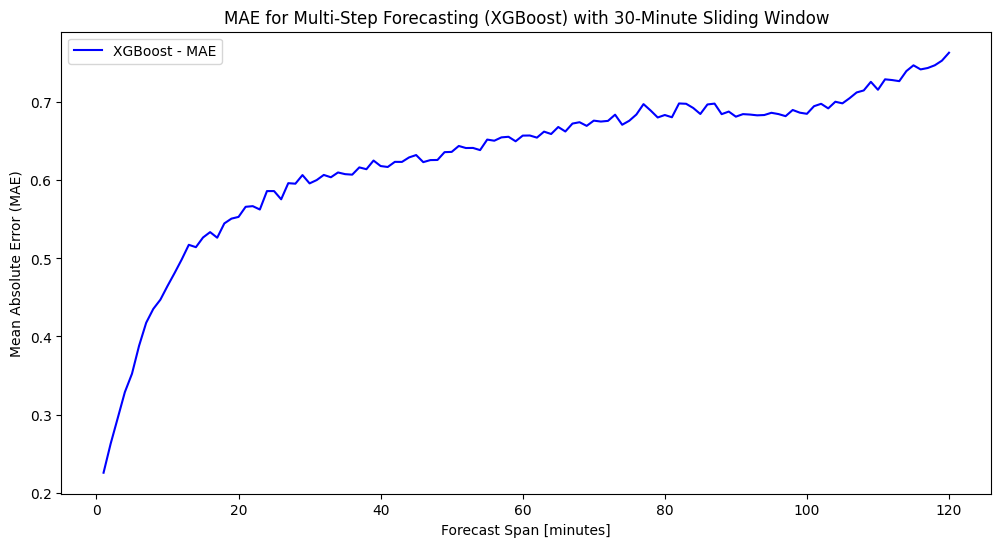

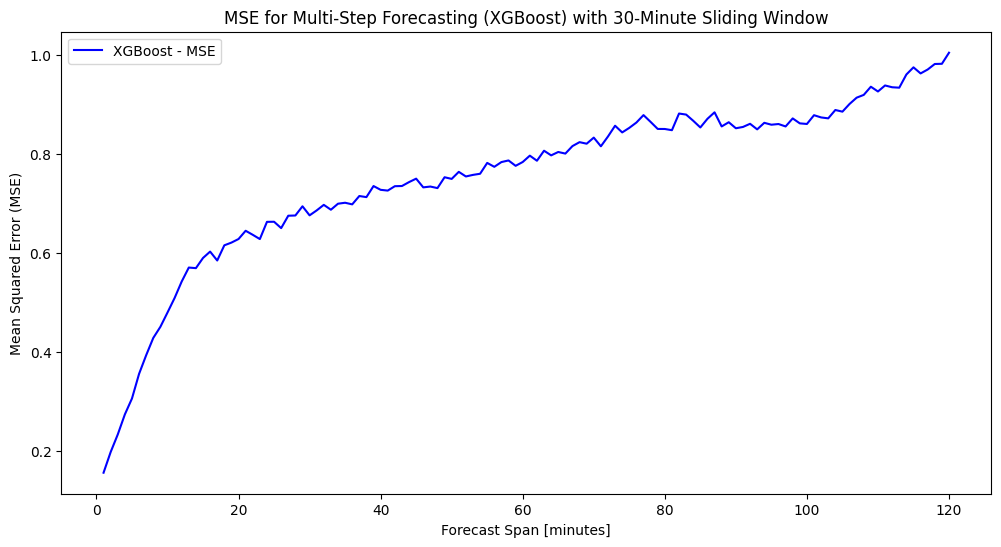

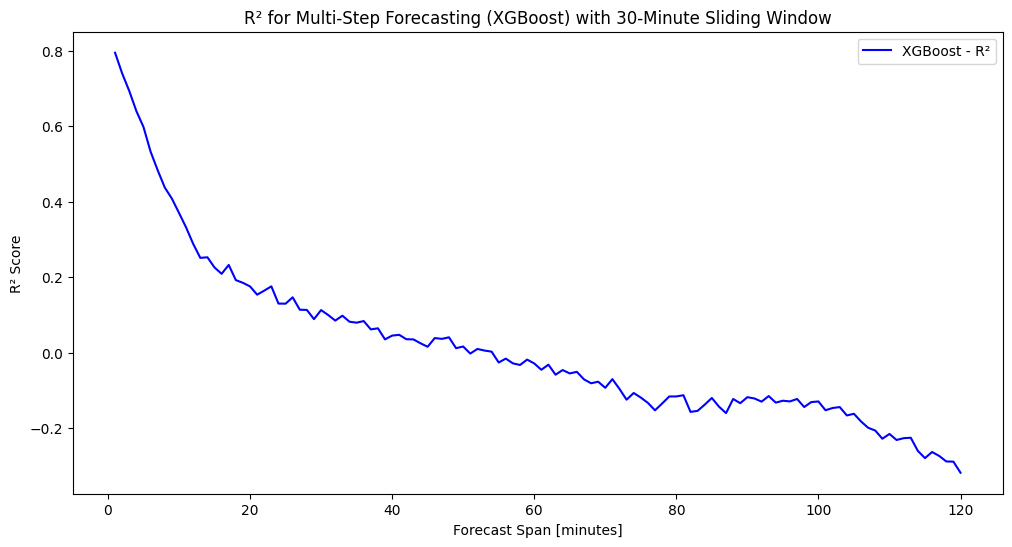

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Make a copy to avoid SettingWithCopyWarning
df = df.copy()

# Select 'Global_active_power' column
df = df[['Global_active_power']]

# Handle missing values correctly
df['Global_active_power'] = df['Global_active_power'].fillna(df['Global_active_power'].mean())

# Create Multi-Step Sliding Window Features (One model per minute ahead)
def create_sliding_window(df, window_size=30, forecast_horizon=120):
    X = []
    y = []

    for i in range(window_size, len(df) - forecast_horizon):
        X.append(df['Global_active_power'].iloc[i-window_size:i].values)  # Last 30 values as features
        y.append(df['Global_active_power'].iloc[i+1:i+forecast_horizon+1].values)  # Next 120 values as target

    return np.array(X), np.array(y)

# Set parameters
window_size = 30  # 30 minutes as input (30 past values)
forecast_horizon = 120  # Predicting next 120 minutes (1 model per minute)

# Create the sliding window data (using 30-minute window and 120 steps ahead)
X, y = create_sliding_window(df, window_size=window_size, forecast_horizon=forecast_horizon)

# Limit training set size to 5,000 samples as per the paper's setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = X_train[:5000]  # Limit to first 5,000 samples
y_train = y_train[:5000]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)  # Reshape for scaling
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)  # Reshape for scaling

# Store MAE, MSE, R² for each forecast step for XGBoost
mae_scores_xgb = np.zeros(forecast_horizon)
mse_scores_xgb = np.zeros(forecast_horizon)
r2_scores_xgb = np.zeros(forecast_horizon)

# Train XGBoost model for each step in the forecast horizon
models_xgb = [xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=10, n_estimators=100) for _ in range(forecast_horizon)]

# Fit the models
for i in range(forecast_horizon):
    models_xgb[i].fit(X_train_scaled, y_train[:, i])  # Train XGBoost model for each step

# Get predictions and calculate metrics for each forecast step
error_xgb = np.zeros_like(y_test)  # To store the prediction errors for calculating variance

for i in range(forecast_horizon):
    y_pred_xgb = models_xgb[i].predict(X_test_scaled)

    # Calculate MAE, MSE, and R² for each step in the forecast horizon
    mae_scores_xgb[i] = mean_absolute_error(y_test[:, i], y_pred_xgb)
    mse_scores_xgb[i] = mean_squared_error(y_test[:, i], y_pred_xgb)
    r2_scores_xgb[i] = r2_score(y_test[:, i], y_pred_xgb)

    # Store errors for variance calculation
    error_xgb[:, i] = y_test[:, i] - y_pred_xgb

# Calculate Error Variance for each forecast step (t+1 to t+120)
error_variance_xgb = np.var(error_xgb, axis=0)

# Plot MAE for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), mae_scores_xgb, label='XGBoost - MAE', color='blue')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title(f'MAE for Multi-Step Forecasting (XGBoost) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot MSE for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), mse_scores_xgb, label='XGBoost - MSE', color='blue')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'MSE for Multi-Step Forecasting (XGBoost) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot R² for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), r2_scores_xgb, label='XGBoost - R²', color='blue')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('R² Score')
plt.title(f'R² for Multi-Step Forecasting (XGBoost) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot Error Variance for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), error_variance_xgb, label='XGBoost - Error Variance', color='blue', marker='o', linestyle='-', markersize=6)

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Error Variance')
plt.title(f'Error Variance for Multi-Step Forecasting (XGBoost) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()


Predictions saved!


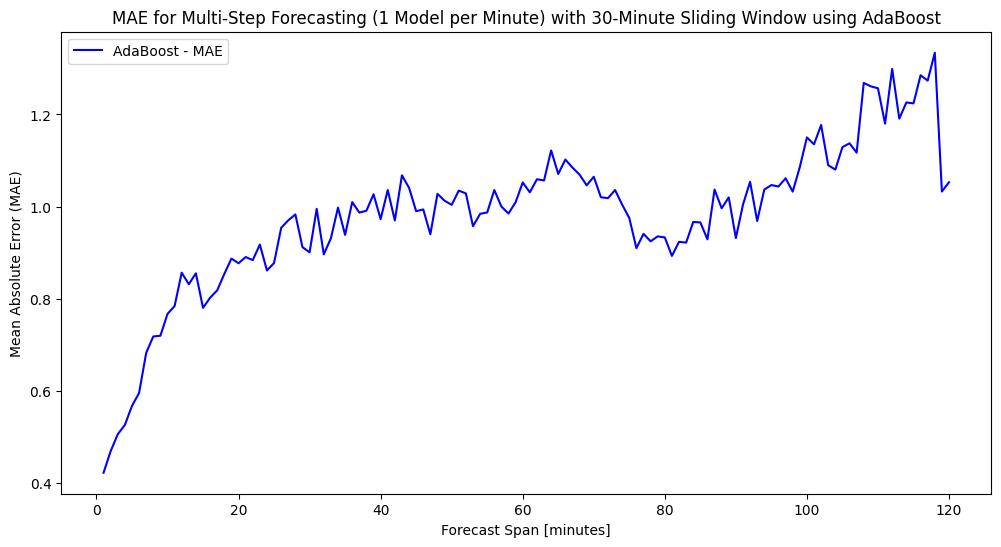

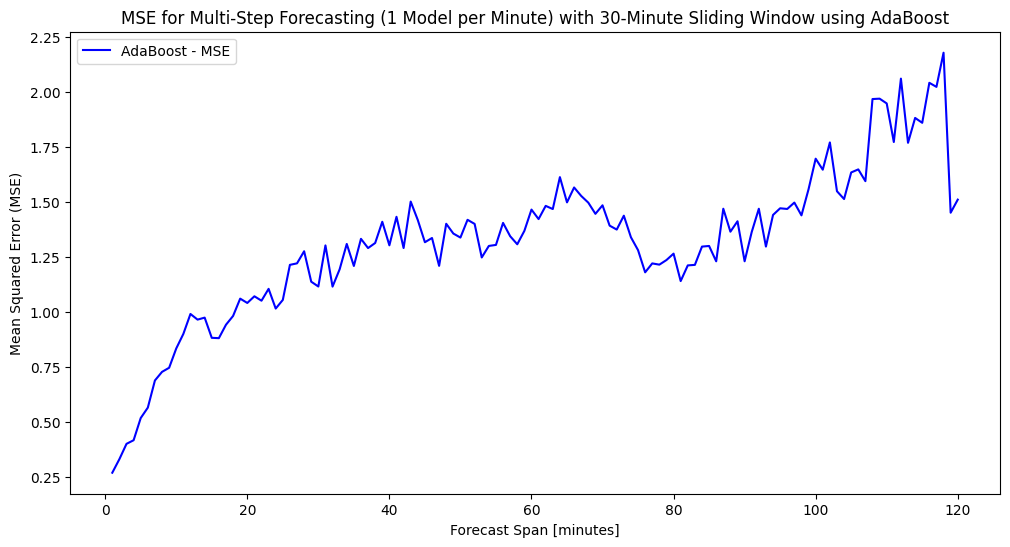

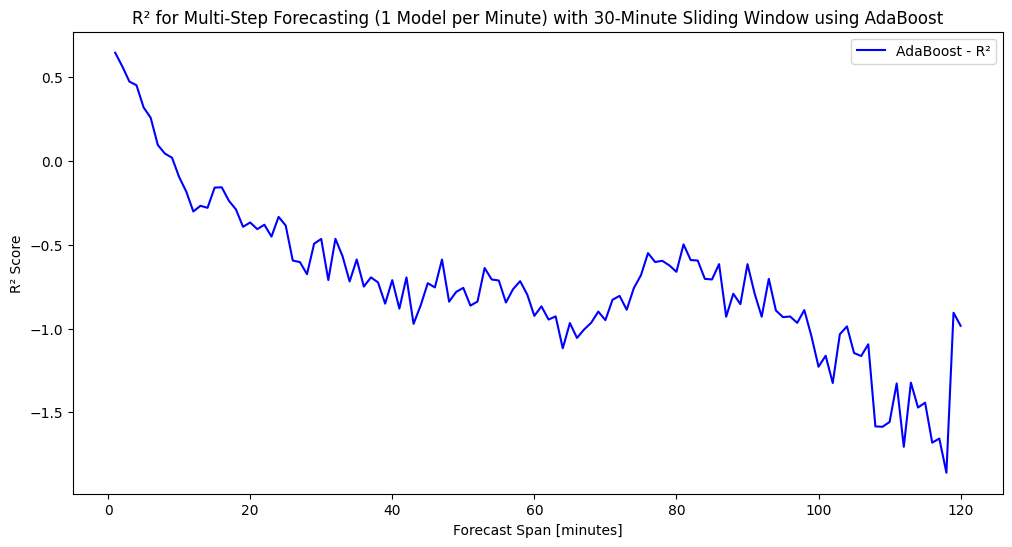

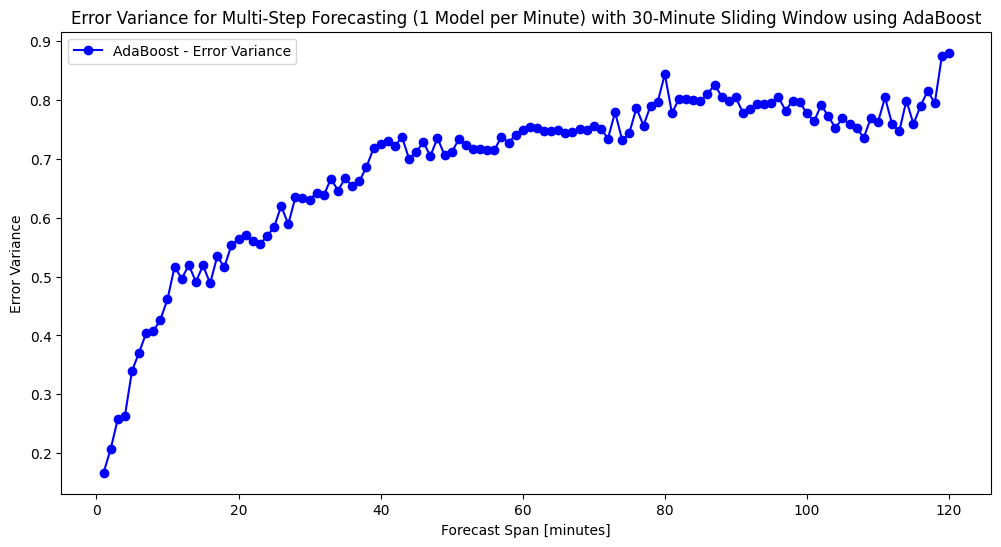

In [7]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Make a copy to avoid SettingWithCopyWarning
df = df.copy()

# Select 'Global_active_power' column
df = df[['Global_active_power']]

# Handle missing values correctly
df['Global_active_power'] = df['Global_active_power'].fillna(df['Global_active_power'].mean())

# Create Multi-Step Sliding Window Features (One model per minute ahead)
def create_sliding_window(df, window_size=30, forecast_horizon=120):
    X = []
    y = []

    for i in range(window_size, len(df) - forecast_horizon):
        X.append(df['Global_active_power'].iloc[i-window_size:i].values)  # Last 30 values as features
        y.append(df['Global_active_power'].iloc[i+1:i+forecast_horizon+1].values)  # Next 120 values as target

    return np.array(X), np.array(y)

# Set parameters
window_size = 30  # 30 minutes as input (30 past values)
forecast_horizon = 120  # Predicting next 120 minutes (1 model per minute)

# Create the sliding window data (using 30-minute window and 120 steps ahead)
X, y = create_sliding_window(df, window_size=window_size, forecast_horizon=forecast_horizon)

# Limit training set size to 5,000 samples as per the paper's setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = X_train[:5000]  # Limit to first 5,000 samples
y_train = y_train[:5000]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)  # Reshape for scaling
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)  # Reshape for scaling

# Store MAE, MSE, R² for each forecast step for both models
mae_scores_ab = np.zeros(forecast_horizon)
mse_scores_ab = np.zeros(forecast_horizon)
r2_scores_ab = np.zeros(forecast_horizon)

# Train models for each step in the forecast horizon using AdaBoost
# Correctly define AdaBoost model without the deprecated 'base_estimator' argument
models_ab = [AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50) for _ in range(forecast_horizon)]  # AdaBoost with Decision Tree as base estimator

# Fit the models
for i in range(forecast_horizon):
    models_ab[i].fit(X_train_scaled, y_train[:, i])  # Train AdaBoost model for each step

# Create arrays to store predictions
y_pred_ab_all = np.zeros_like(y_test)  # Shape: (n_samples, forecast_horizon)

# Get predictions and calculate errors for each forecast step
for i in range(forecast_horizon):
    y_pred_ab = models_ab[i].predict(X_test_scaled)

    # Store the predictions for each forecast step
    y_pred_ab_all[:, i] = y_pred_ab

    # Calculate MAE, MSE, and R² for each step in the forecast horizon
    mae_scores_ab[i] = mean_absolute_error(y_test[:, i], y_pred_ab)
    mse_scores_ab[i] = mean_squared_error(y_test[:, i], y_pred_ab)
    r2_scores_ab[i] = r2_score(y_test[:, i], y_pred_ab)

# Save the predictions to disk (after all steps)
np.save('y_pred_ab_all.npy', y_pred_ab_all)

print("Predictions saved!")

# Calculate Error Variance for each forecast step (t+1 to t+120)
error_ab = np.zeros_like(y_test)

# Get predictions and calculate errors for each forecast step
for i in range(forecast_horizon):
    y_pred_ab = models_ab[i].predict(X_test_scaled)

    # Store the errors for each step
    error_ab[:, i] = y_test[:, i] - y_pred_ab

# Calculate Error Variance for each forecast step (t+1 to t+120)
error_variance_ab = np.var(error_ab, axis=0)

# Plot MAE for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), mae_scores_ab, label='AdaBoost - MAE', color='blue')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title(f'MAE for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window using AdaBoost')
plt.legend()
plt.grid(False)
plt.show()

# Plot MSE for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), mse_scores_ab, label='AdaBoost - MSE', color='blue')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'MSE for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window using AdaBoost')
plt.legend()
plt.grid(False)
plt.show()

# Plot R² for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), r2_scores_ab, label='AdaBoost - R²', color='blue')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('R² Score')
plt.title(f'R² for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window using AdaBoost')
plt.legend()
plt.grid(False)
plt.show()

# Plot Error Variance for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), error_variance_ab, label='AdaBoost - Error Variance', color='blue', marker='o', linestyle='-', markersize=6)

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Error Variance')
plt.title(f'Error Variance for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window using AdaBoost')
plt.legend()
plt.grid(False)
plt.show()


Saving Predictions

Predictions saved!


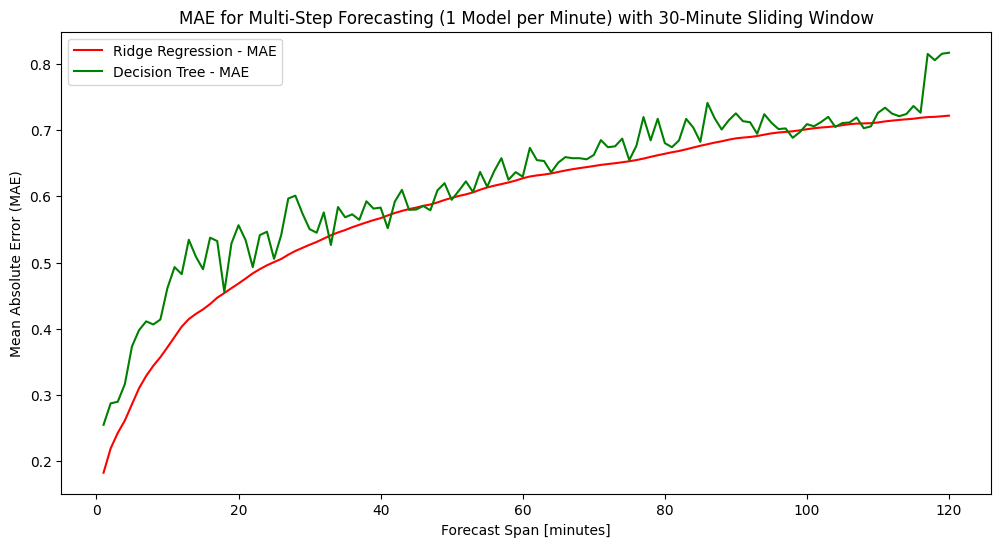

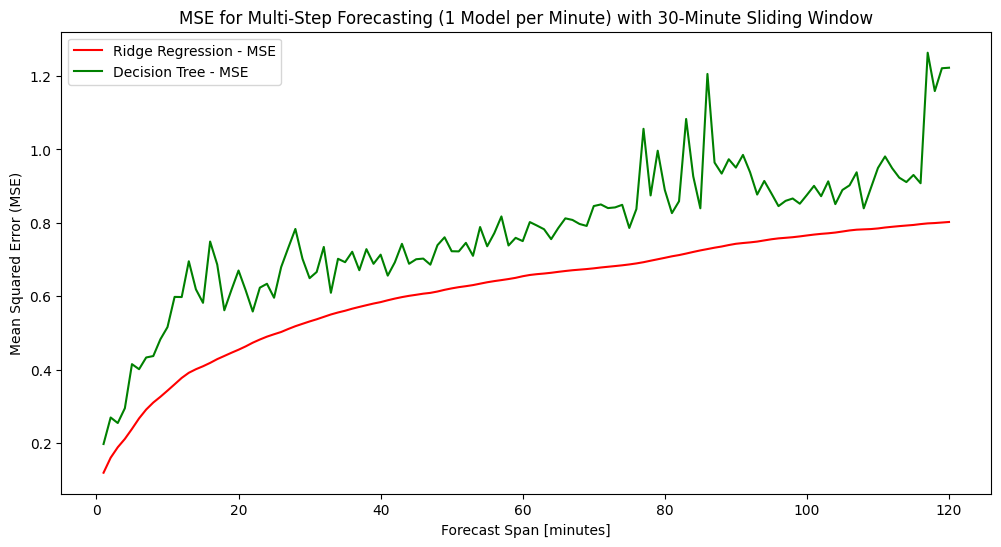

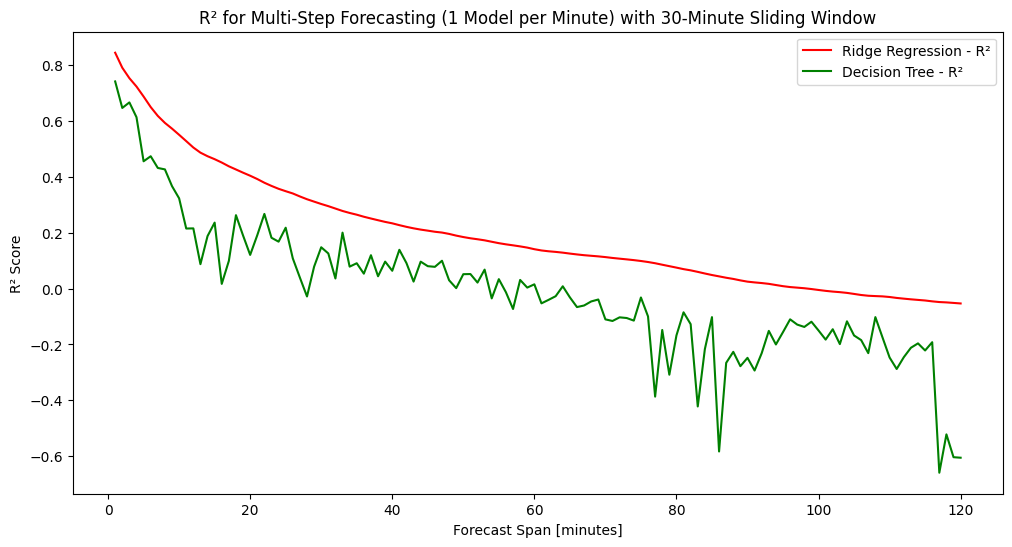

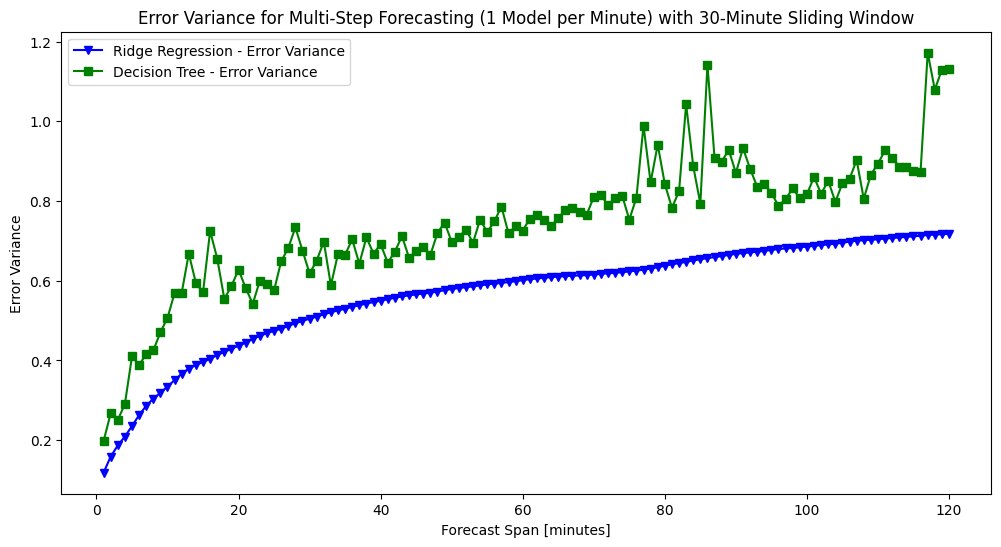

In [8]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Make a copy to avoid SettingWithCopyWarning
df = df.copy()

# Select 'Global_active_power' column
df = df[['Global_active_power']]

# Handle missing values correctly
df['Global_active_power'] = df['Global_active_power'].fillna(df['Global_active_power'].mean())

# Create Multi-Step Sliding Window Features (One model per minute ahead)
def create_sliding_window(df, window_size=30, forecast_horizon=120):
    X = []
    y = []

    for i in range(window_size, len(df) - forecast_horizon):
        X.append(df['Global_active_power'].iloc[i-window_size:i].values)  # Last 30 values as features
        y.append(df['Global_active_power'].iloc[i+1:i+forecast_horizon+1].values)  # Next 120 values as target

    return np.array(X), np.array(y)

# Set parameters
window_size = 30  # 30 minutes as input (30 past values)
forecast_horizon = 120  # Predicting next 120 minutes (1 model per minute)

# Create the sliding window data (using 30-minute window and 120 steps ahead)
X, y = create_sliding_window(df, window_size=window_size, forecast_horizon=forecast_horizon)

# Limit training set size to 5,000 samples as per the paper's setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = X_train[:5000]  # Limit to first 5,000 samples
y_train = y_train[:5000]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)  # Reshape for scaling
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)  # Reshape for scaling

# Store MAE, MSE, R² for each forecast step for both models
mae_scores_lr = np.zeros(forecast_horizon)
mse_scores_lr = np.zeros(forecast_horizon)
r2_scores_lr = np.zeros(forecast_horizon)

mae_scores_dt = np.zeros(forecast_horizon)
mse_scores_dt = np.zeros(forecast_horizon)
r2_scores_dt = np.zeros(forecast_horizon)

# Train models for each step in the forecast horizon
models_lr = [Ridge(alpha=1.0) for _ in range(forecast_horizon)]  # Ridge regularization for Linear Regression
models_dt = [DecisionTreeRegressor(max_depth=5, max_features='log2', min_samples_leaf=4, min_samples_split=2) for _ in range(forecast_horizon)]  # Best parameters for Decision Tree

# Fit the models
for i in range(forecast_horizon):
    models_lr[i].fit(X_train_scaled, y_train[:, i])  # Train Ridge model for each step
    models_dt[i].fit(X_train_scaled, y_train[:, i])  # Train Decision Tree model for each step

# Create arrays to store predictions
y_pred_ridge_all = np.zeros_like(y_test)  # Shape: (n_samples, forecast_horizon)
y_pred_dt_all = np.zeros_like(y_test)  # Shape: (n_samples, forecast_horizon)

# Get predictions and calculate errors for each forecast step
for i in range(forecast_horizon):
    y_pred_lr = models_lr[i].predict(X_test_scaled)
    y_pred_dt = models_dt[i].predict(X_test_scaled)

    # Store the predictions for each forecast step
    y_pred_ridge_all[:, i] = y_pred_lr
    y_pred_dt_all[:, i] = y_pred_dt

    # Calculate MAE, MSE, and R² for each step in the forecast horizon
    mae_scores_lr[i] = mean_absolute_error(y_test[:, i], y_pred_lr)
    mse_scores_lr[i] = mean_squared_error(y_test[:, i], y_pred_lr)
    r2_scores_lr[i] = r2_score(y_test[:, i], y_pred_lr)

    mae_scores_dt[i] = mean_absolute_error(y_test[:, i], y_pred_dt)
    mse_scores_dt[i] = mean_squared_error(y_test[:, i], y_pred_dt)
    r2_scores_dt[i] = r2_score(y_test[:, i], y_pred_dt)

# Save the predictions to disk (after all steps)
np.save('y_pred_ridge_all.npy', y_pred_ridge_all)
np.save('y_pred_dt_all.npy', y_pred_dt_all)

print("Predictions saved!")

# Calculate Error Variance for each forecast step (t+1 to t+120)
error_ridge = np.zeros_like(y_test)
error_dt = np.zeros_like(y_test)

# Get predictions and calculate errors for each forecast step
for i in range(forecast_horizon):
    y_pred_lr = models_lr[i].predict(X_test_scaled)
    y_pred_dt = models_dt[i].predict(X_test_scaled)

    # Store the errors for each step
    error_ridge[:, i] = y_test[:, i] - y_pred_lr
    error_dt[:, i] = y_test[:, i] - y_pred_dt

# Calculate Error Variance for each forecast step (t+1 to t+120)
error_variance_ridge = np.var(error_ridge, axis=0)
error_variance_dt = np.var(error_dt, axis=0)

# Plot MAE for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), mae_scores_lr, label='Ridge Regression - MAE', color='red')
plt.plot(np.arange(1, forecast_horizon + 1), mae_scores_dt, label='Decision Tree - MAE', color='green')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title(f'MAE for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot MSE for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), mse_scores_lr, label='Ridge Regression - MSE', color='red')
plt.plot(np.arange(1, forecast_horizon + 1), mse_scores_dt, label='Decision Tree - MSE', color='green')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'MSE for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot R² for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), r2_scores_lr, label='Ridge Regression - R²', color='red')
plt.plot(np.arange(1, forecast_horizon + 1), r2_scores_dt, label='Decision Tree - R²', color='green')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('R² Score')
plt.title(f'R² for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot Error Variance for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), error_variance_ridge, label='Ridge Regression - Error Variance', color='blue', marker='v', linestyle='-', markersize=6)
plt.plot(np.arange(1, forecast_horizon + 1), error_variance_dt, label='Decision Tree - Error Variance', color='green', marker='s', linestyle='-', markersize=6)

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Error Variance')
plt.title(f'Error Variance for Multi-Step Forecasting (1 Model per Minute) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()


Predictions saved!


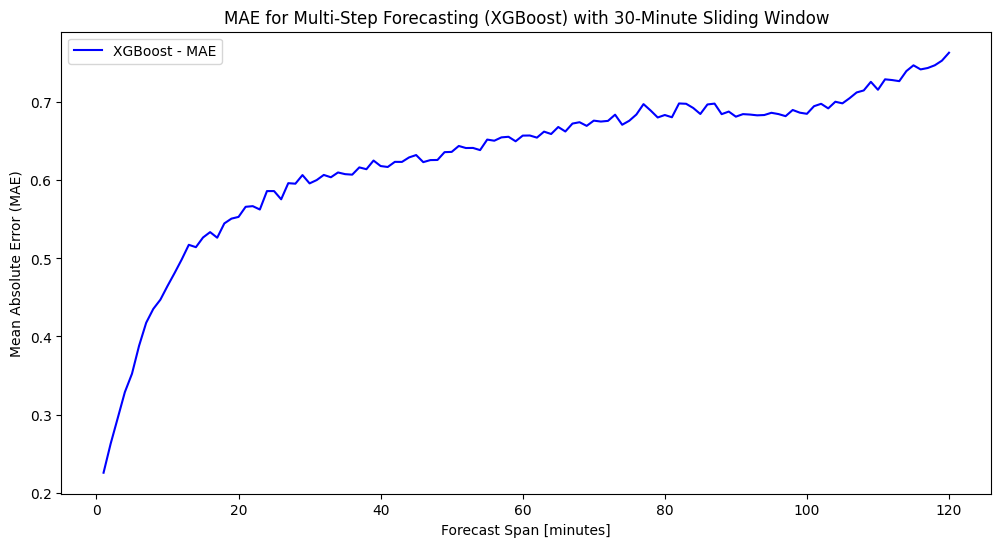

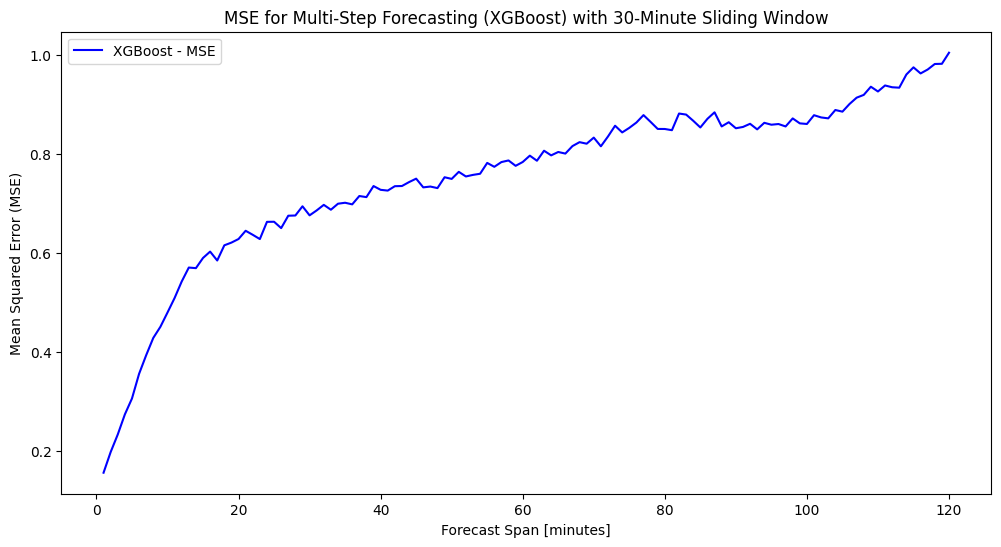

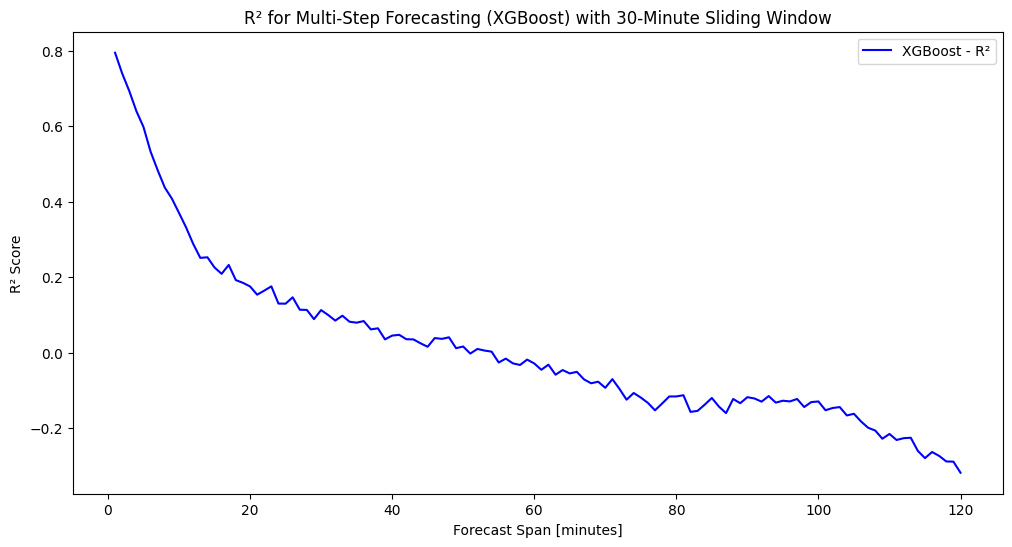

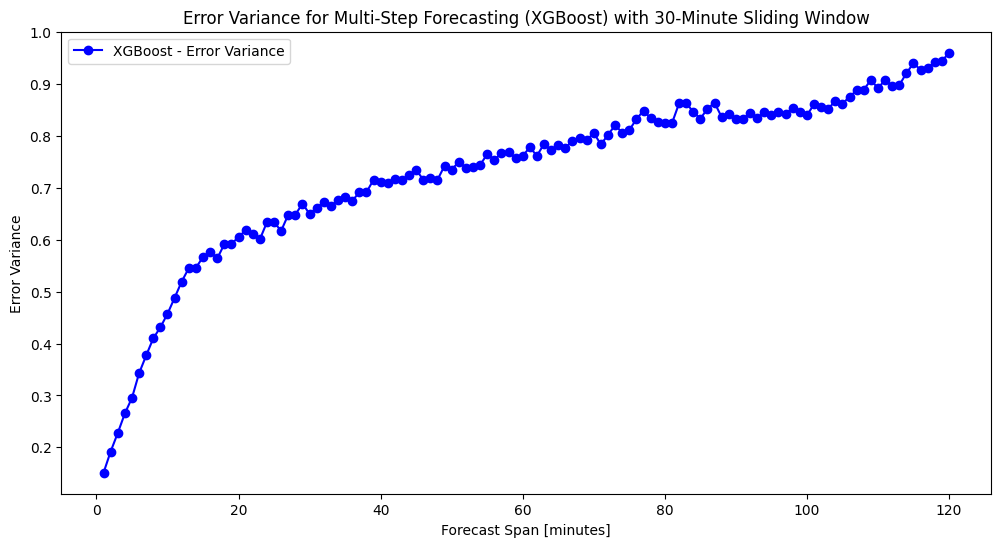

In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Make a copy to avoid SettingWithCopyWarning
df = df.copy()

# Select 'Global_active_power' column
df = df[['Global_active_power']]

# Handle missing values correctly
df['Global_active_power'] = df['Global_active_power'].fillna(df['Global_active_power'].mean())

# Create Multi-Step Sliding Window Features (One model per minute ahead)
def create_sliding_window(df, window_size=30, forecast_horizon=120):
    X = []
    y = []

    for i in range(window_size, len(df) - forecast_horizon):
        X.append(df['Global_active_power'].iloc[i-window_size:i].values)  # Last 30 values as features
        y.append(df['Global_active_power'].iloc[i+1:i+forecast_horizon+1].values)  # Next 120 values as target

    return np.array(X), np.array(y)

# Set parameters
window_size = 30  # 30 minutes as input (30 past values)
forecast_horizon = 120  # Predicting next 120 minutes (1 model per minute)

# Create the sliding window data (using 30-minute window and 120 steps ahead)
X, y = create_sliding_window(df, window_size=window_size, forecast_horizon=forecast_horizon)

# Limit training set size to 5,000 samples as per the paper's setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = X_train[:5000]  # Limit to first 5,000 samples
y_train = y_train[:5000]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)  # Reshape for scaling
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)  # Reshape for scaling

# Store MAE, MSE, R² for each forecast step for XGBoost
mae_scores_xgb = np.zeros(forecast_horizon)
mse_scores_xgb = np.zeros(forecast_horizon)
r2_scores_xgb = np.zeros(forecast_horizon)

# Train XGBoost model for each step in the forecast horizon
models_xgb = [xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=10, n_estimators=100) for _ in range(forecast_horizon)]

# Fit the models
for i in range(forecast_horizon):
    models_xgb[i].fit(X_train_scaled, y_train[:, i])  # Train XGBoost model for each step

# Create arrays to store predictions
y_pred_xgb_all = np.zeros_like(y_test)  # Shape: (n_samples, forecast_horizon)

# Get predictions and calculate metrics for each forecast step
error_xgb = np.zeros_like(y_test)  # To store the prediction errors for calculating variance

for i in range(forecast_horizon):
    y_pred_xgb = models_xgb[i].predict(X_test_scaled)

    # Store the predictions for each forecast step
    y_pred_xgb_all[:, i] = y_pred_xgb

    # Calculate MAE, MSE, and R² for each step in the forecast horizon
    mae_scores_xgb[i] = mean_absolute_error(y_test[:, i], y_pred_xgb)
    mse_scores_xgb[i] = mean_squared_error(y_test[:, i], y_pred_xgb)
    r2_scores_xgb[i] = r2_score(y_test[:, i], y_pred_xgb)

    # Store errors for variance calculation
    error_xgb[:, i] = y_test[:, i] - y_pred_xgb

# Save the predictions to disk (after all steps)
np.save('y_pred_xgb_all.npy', y_pred_xgb_all)

print("Predictions saved!")

# Calculate Error Variance for each forecast step (t+1 to t+120)
error_variance_xgb = np.var(error_xgb, axis=0)

# Plot MAE for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), mae_scores_xgb, label='XGBoost - MAE', color='blue')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title(f'MAE for Multi-Step Forecasting (XGBoost) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot MSE for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), mse_scores_xgb, label='XGBoost - MSE', color='blue')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'MSE for Multi-Step Forecasting (XGBoost) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot R² for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), r2_scores_xgb, label='XGBoost - R²', color='blue')

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('R² Score')
plt.title(f'R² for Multi-Step Forecasting (XGBoost) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()

# Plot Error Variance for each forecast step
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, forecast_horizon + 1), error_variance_xgb, label='XGBoost - Error Variance', color='blue', marker='o', linestyle='-', markersize=6)

plt.xlabel('Forecast Span [minutes]')
plt.ylabel('Error Variance')
plt.title(f'Error Variance for Multi-Step Forecasting (XGBoost) with 30-Minute Sliding Window')
plt.legend()
plt.grid(False)
plt.show()
